In [1]:
import math
import numpy 
import matplotlib.pyplot as pp
from itertools import permutations
from itertools import combinations
from collections import deque
import random
import copy
%matplotlib notebook
import matplotlib.pyplot as pp
from scipy.spatial import ConvexHull

In [2]:
num_kin = 11
location = numpy.loadtxt('location.txt')

In [3]:
def drawLocation(location):
    x = []
    y = []
    n = range(num_kin)
    for kin in location:
        x.append(kin[0])
        y.append(kin[1])
    pp.scatter(x,y)
    for i, txt in enumerate(n):
        pp.annotate(txt, (x[i], y[i]))
    pp.title('Map of kindergartens in latitude and longtitude')
    pp.xlabel('Latitude')
    pp.ylabel('Longitude')
    pp.show()

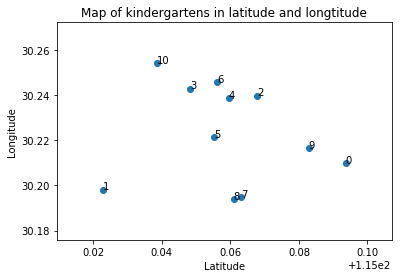

In [4]:
drawLocation(location)

In [5]:
weight = [[math.inf, 21.17, 12.62, 14.48, 11.25, 11.57, 13.20, 11.17, 12.25, 5.60, 18.52],
        [20.22, math.inf, 23.12, 15.73, 17.37, 13.98, 17.30, 14.37, 15.07, 12.08, 18.37],
        [12.23, 22.53, math.inf, 9.05, 3.55, 10.52, 6.13, 19.02, 20.93, 8.05, 11.40],
        [14.38, 13.35, 8.07, math.inf, 3.88, 7.42, 3.45, 18.25, 20.22, 9.82, 6.75],
        [10.77, 16.52, 5.70, 4.57, math.inf, 6.47, 3.57, 17.45, 18.50, 8.07, 9.73],
        [11.25, 14.42, 11.03, 8.30, 6.75, math.inf, 8.30, 15.07, 16.12, 7.08, 13.02],
        [13.38, 15.33, 5.78, 4.13, 3.20, 7.87, math.inf, 18.55, 20.77, 10.43, 8.83],
        [11.63, 14.22, 23.18, 21.28, 18.40, 17.00, 21.42, math.inf, 1.75, 13.27, 24.35],
        [11.42, 14.55, 22.95, 21.00, 18.13, 16.33, 21.13, 5.85, math.inf, 12.98, 24.07],
        [5.60, 12.05, 9.22, 10.68, 9.25, 7.92, 10.23, 11.05, 11.78, math.inf, 16.20],
        [19.72, 15.37, 11.05, 7.03, 9.53, 12.82, 8.90, 23.25, 24.30, 15.48, math.inf]]

book_unit = {0:6, 1:3, 2:5, 3:4, 4:5, 5:2, 6:3, 7:3, 8:3, 9:3, 10:3}

# types WMlife has  
type_best = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9']
type_other = ['O1', 'O2', 'O3', 'O4', 'O5', 'O6', 'O7', 'O8', 'O9']

# Finding Starting point

In [6]:
convex_hull = []
hull = ConvexHull(location)
for vertices in hull.vertices:
    convex_hull.append(vertices)
convex_hull

[10, 1, 8, 7, 0, 2, 6]

# Clustering Kindergartens into Groups

In [7]:
# return the next nearest point in the map for the 
# group with starting point 'start'.
def findNearPoint(cluster, start, temp_weight):
    min_time = -1
    min_kin = -1
    for j in cluster[start]:
        temp = min(temp_weight[j])
        if min_time == -1 or min_time > temp:
            min_time = temp
            min_kin = temp_weight[j].index(min(temp_weight[j]))
            #print('next_min_kin', min_kin)
    return(min_time, min_kin)

In [8]:
# find the nearest group for min_kin, and return the starting point of the group.
# and the time used to travel from nearest_start -> min_kin
def findNearGroup(cluster, start, temp_weight, min_time, next_start, min_kin):
    nearest_start = next_start
    for s in start:
        if s != next_start:
            #print('s', s)
            for g in cluster[s]:
                temp = (temp_weight[g][min_kin] + temp_weight[min_kin][g]) / 2
                if min_time == -1 or temp < min_time:
                    min_time = temp
                    nearest_start = s
                    #nearest_kin = g
    return(nearest_start, min_time) #, nearest_kin)

In [9]:
# reassign groups that has > 6 kins
def reassignLarge(cluster, start, temp_weight):
    if all(len(cluster[c]) <= 6 for c in start):
        return(cluster)
    else:
        for c in start:
            # regroup cluster has more than 6 kins
            if len(cluster[c]) > 6:
                min_time = -1
                min_k_regroup = -1 # the kin needs to regroup
                min_start = -1 # the original cluster of regroup kin
                min_near_start = -1 # the nearest starting point for min_k_regroup
                # iterate through kin in this cluster, 
                # compare all time from min travel time from 
                # each kin to kin in other cluster 
                for k in cluster[c]:
                    (nearest_group, 
                     local_min_time) = findNearGroup(cluster, start, 
                                                     temp_weight, 
                                                     min_time, c, k)
                    if min_time == -1 or min_time > local_min_time:
                        min_time = local_min_time
                        min_k_regroup = k
                        min_start = c
                        min_near_start = nearest_group
                for kin in cluster[min_start]:
                    temp_weight[min_k_regroup][kin] = math.inf
                    temp_weight[kin][min_k_regroup] = math.inf
                cluster[min_start].remove(min_k_regroup)
                cluster[min_near_start].append(min_k_regroup)
        return(reassignLarge(cluster, start, temp_weight))

In [10]:
def assignGroups(start, weight):
    temp_weight = copy.deepcopy(weight)
    cluster = {}
    all_kin = list(range(num_kin))
    add_on_kin = []
    # keys are the starting point we choose
    for k in start:
        cluster[k] = [k]
        all_kin.remove(k)
        add_on_kin.append(k)
    # all_kin is the kindergarten we have not clustered yet
    while len(all_kin) > 0:
        next_start_list = [k for k in cluster.keys() if len(cluster.get(k))== 
                        min([len(n) for n in cluster.values()])]
        rand = numpy.random.randint(0, len(next_start_list))
        next_start = next_start_list[rand]
        (min_time, min_kin) = findNearPoint(cluster, next_start, temp_weight)
        #print('min_kin', min_kin)
        #print('min_time', min_time)
        (nearest_start, 
         min_time) = findNearGroup(cluster, start, weight,
                                   min_time, next_start, min_kin)
                #(time, kin) = findNearGroup(cluster, s, temp_weight)
                #if min_time > time:
                    #min_time = time
                    #min_kin = kin

        if len(all_kin) > 0:
            #print(min_kin)
            #print(min_time)
            #print('all_kin', all_kin)
            all_kin.remove(min_kin)
            for n in add_on_kin:
                temp_weight[min_kin][n] = math.inf
                temp_weight[n][min_kin] = math.inf
            add_on_kin.append(min_kin)
            cluster[nearest_start].append(min_kin)
            #print(cluster)
    return(reassignLarge(cluster, start, copy.deepcopy(weight)))

In [11]:
start_point = [7, 10]
#temp_weight = copy.deepcopy(weight)
cluster = assignGroups(start_point, weight)
#cluster = reassignLarge(cluster_large_group, start_point, temp_weight)
print('Cluster:', cluster)

Cluster: {7: [7, 8, 0, 9, 1], 10: [10, 3, 6, 4, 2, 5]}


# Find Minimum Route in Clusters

In [12]:
# Find all possible route to visit each kindergarten once
def findAllRoute(group):
    perm = permutations(group)
    all_route = [] # perm_list--》all route
    for i in perm:
        all_route.append(i)
    return(all_route)

In [13]:
# input: a list of int representing the order of the tour 
# output: return the total distance traveled in the given order 
# of the tour
def sumTour(time_weight, tour):
    sum_tour = 0
    temp = tour[-1]
    for i in tour:
        sum_tour += time_weight[temp][i]
        temp = i
    return int(sum_tour)

In [14]:
# this function find the shortest tour that visits all 
# kindergartens by brute-force search it takes in a list of 
# all possible routes in an TSP problem and find the shortest 
# one among them it return and print the shortest route and 
# the shortest time under that route 
# shortest_time is the shortest time in travel_time 
def TSP_solver(time_weight, group):
    all_route = findAllRoute(group)
    travel_time = []
    for i in range(len(all_route)):
        travel_time.append(sumTour(time_weight, all_route[i]))
    shortest_time = min(travel_time)
    return (shortest_time, travel_time) 

In [15]:
# construct a dictionary, key: the time needed for travel, value: the tour
# Find the shortest tours
def shortestTours(group):
    all_route = findAllRoute(group)
    (shortest_time, travel_time) = TSP_solver(weight, group)
    #print('Shortest time:',shortest_time,"min")
    time_dict = {}
    count = 0
    for time in travel_time:
        if time not in time_dict:
            time_dict[time] = []
        time_dict[time].append(all_route[count])
        count += 1
    shortest_tour_list = time_dict[shortest_time]
    #print('The tour with the shortest travel time:', shortest_tour_list)
    return(time_dict)

In [16]:
# find kindergarten with largest book units and return a 
# interger(position of kindergarten in the list)
def findMaxKin(group):
    max_unit = 0
    max_kin = -1
    for kin in group:
        temp = book_unit[kin]
        if max_unit == 0 or max_unit < temp:
            max_unit = temp
            max_kin = kin
    return(max_kin)

In [17]:
# find the shortest route begin with the 
# kindergarten with largest book units
def shortestTour(time_dict, group):
    optimal_tour = []
    #print(time_dict)
    #(shortest_time, travel_time) = TSP_solver(weight, group)
    #print(shortest_time)
    #print(findMaxKin(group))
    for tour in time_dict[min(time_dict)]:
        if tour[0] == findMaxKin(group):
            optimal_tour = tour
    return(optimal_tour)

In [18]:
for start in start_point:
    (shortest_time, travel_time) = TSP_solver(weight, cluster[start])
    print('Time cost:', shortest_time, 'min for '
          'Tour:', shortestTour(shortestTours(cluster[start]), cluster[start]))

Time cost: 45 min for Tour: (0, 9, 1, 7, 8)
Time cost: 39 min for Tour: (4, 5, 3, 10, 6, 2)


# Assign Types to Kindergartens

In [19]:
# Add type to initial kindergarten
# if book type <= 3, all best types, if > 3, 3 best types, 
# other types for the rest of them.
def bookType(tour):  
    # types WMlife has  
    best = copy.deepcopy(deque(type_best))
    other = copy.deepcopy(deque(type_other))
    book_type = {}
    for i in range(len(tour)):
        book_type[tour[i]] = []
        if book_unit[tour[i]] <= 3:
            for num in range(book_unit[tour[i]]):
                temp = best.popleft()
                book_type[tour[i]].append(temp)
                best.append(temp)
        else:
            for num in range(3):
                temp = best.popleft()
                book_type[tour[i]].append(temp)
                best.append(temp)
            for num in range(book_unit[tour[i]]-3):
                temp = other.popleft()
                book_type[tour[i]].append(temp)
                other.append(temp)
                
    # if the last one has the same type with the first one, change them.
    last_first_diff = set(book_type[tour[len(tour)-1]]) and set(book_type[tour[len(tour)-1]])
    all_best_type = set(type_best)
    all_other_type = set(type_other)
    if len(last_first_diff) != 0 & len(tour) > 1:
        near_type = set(book_type[tour[len(tour)-2]] + book_type[tour[0]])
        last_first_best_diff = last_first_diff - all_best_type
        last_first_other_diff = last_first_diff - all_other_type
        for same in last_first_diff:
            book_type[tour[len(tour)-1]].remove(same)
        if len(last_first_best_diff) != 0:
            last_kin_best_type = all_best_type - near_type    
            for i in range(len(last_first_best_diff)):
                book_type[tour[len(tour)-1]].append(last_kin_best_type.pop())
        # other type repetitive
        if len(last_first_other_diff) != 0:
            last_kin_other_type = all_other_type - near_type
            for i in range(len(last_first_other_diff)):
                book_type[tour[len(tour)-1]].append(last_kin_other_type.pop())
            
    return(book_type)

In [20]:
book_types = {}
for start in start_point:
    book_type = bookType(shortestTour(shortestTours(cluster[start]), cluster[start]))
    print(book_type)
    book_types.update(book_type)

{0: ['B1', 'B2', 'B3', 'O1', 'O2', 'O3'], 9: ['B4', 'B5', 'B6'], 1: ['B7', 'B8', 'B9'], 7: ['B1', 'B2', 'B3'], 8: ['B4', 'B5', 'B6']}
{4: ['B1', 'B2', 'B3', 'O1', 'O2'], 5: ['B4', 'B5'], 3: ['B6', 'B7', 'B8', 'O3'], 10: ['B9', 'B1', 'B2'], 6: ['B3', 'B4', 'B5'], 2: ['B6', 'B7', 'B8', 'O4', 'O5']}


In [21]:
# Purchasing Book Type
print(book_types)

{0: ['B1', 'B2', 'B3', 'O1', 'O2', 'O3'], 9: ['B4', 'B5', 'B6'], 1: ['B7', 'B8', 'B9'], 7: ['B1', 'B2', 'B3'], 8: ['B4', 'B5', 'B6'], 4: ['B1', 'B2', 'B3', 'O1', 'O2'], 5: ['B4', 'B5'], 3: ['B6', 'B7', 'B8', 'O3'], 10: ['B9', 'B1', 'B2'], 6: ['B3', 'B4', 'B5'], 2: ['B6', 'B7', 'B8', 'O4', 'O5']}


# Change Types in Clusters

In [22]:
def changeable(k_name, kbooktype, dropoff):
    count = 1
    temp_set = set(dropoff)
    count = 0
    for i in dropoff:   
        if len(temp_set) != len(dropoff):
            return "false"       
        elif i in kbooktype[k_name]:
            count += 1
    if count >= len(kbooktype)*(1-0.75):
        return "false"
    
    return "true"

In [23]:
def change1(k_name, truck, kbooktype, solution):
    if (k_name == 0) and (changeable(0, kbooktype, truck) == "true") : 
        solution[0] = truck
        #print(truck)
        #print("It works!")
        return solution
    else:
        #print(k_name)
        comb_t = combinations(truck, len(kbooktype[k_name]))
        for i in comb_t:
            if changeable(k_name, kbooktype, i) == "true":
                record_truck = copy.deepcopy(truck) 
                #print(truck)


                truck = truck + kbooktype[k_name]
                #print(truck)


                solution[k_name] = i

                #print(i)
                for j in i:
                    truck.remove(j)
                
                #print(truck)


                ret = change1((k_name+1) % len(kbooktype), truck, kbooktype, solution)
                if (ret != 0):
                    return ret
                
                truck = record_truck
                
        return 0

In [24]:
def changeTypeMain(group):
    result = 0
    allTour = copy.deepcopy(shortestTours(group))
    while result == 0:
        kbooktype = []
        shortest_time = min(allTour)
        for i in shortestTour(allTour, group):
            kbooktype.append(book_types[i])
        #print(kbooktype)
        truck = kbooktype[0]
        solution = copy.deepcopy(kbooktype)
        result = change1(1, truck, kbooktype, solution)
        allTour.pop(shortest_time)
    return (result, shortest_time)

In [25]:
def instructions():
    print('Kindergartens are clustered into', len(start_point), 'groups')
    for i in range(len(start_point)):
        (reallocation, shortest_time) = changeTypeMain(cluster[start_point[i]])
        tour = shortestTour(shortestTours(cluster[start_point[i]]), cluster[start_point[i]])
        print('Cluster', i, ':', tour)
        print('Truck starts from kindergarton', tour[0])
        k = 0
        while k != len(cluster[start_point[i]])-1:
            print('Truck picks up', book_types[k], 'from kindergarten', tour[k])
            k += 1
            print('Truck travels to kindergarten', str(tour[k])+',', 'and loads off', list(reallocation[k]))
        print('Truck picks up', book_types[k], 'from kindergarten', tour[k])
        print('Truck travels back to kindergarten', str(tour[0])+',', 'and loads off', list(reallocation[0]))
        print('Traveling time through all kindergartens is:', shortest_time, 'min')
        print()

In [26]:
instructions()

Kindergartens are clustered into 2 groups
Cluster 0 : (0, 9, 1, 7, 8)
Truck starts from kindergarton 0
Truck picks up ['B1', 'B2', 'B3', 'O1', 'O2', 'O3'] from kindergarten 0
Truck travels to kindergarten 9, and loads off ['B1', 'B2', 'B3']
Truck picks up ['B7', 'B8', 'B9'] from kindergarten 9
Truck travels to kindergarten 1, and loads off ['O1', 'O2', 'O3']
Truck picks up ['B6', 'B7', 'B8', 'O4', 'O5'] from kindergarten 1
Truck travels to kindergarten 7, and loads off ['B4', 'B5', 'B6']
Truck picks up ['B6', 'B7', 'B8', 'O3'] from kindergarten 7
Truck travels to kindergarten 8, and loads off ['B7', 'B1', 'B2']
Truck picks up ['B1', 'B2', 'B3', 'O1', 'O2'] from kindergarten 8
Truck travels back to kindergarten 0, and loads off ['B8', 'B9', 'B3', 'B4', 'B5', 'B6']
Traveling time through all kindergartens is: 45 min

Cluster 1 : (4, 5, 3, 10, 6, 2)
Truck starts from kindergarton 4
Truck picks up ['B1', 'B2', 'B3', 'O1', 'O2', 'O3'] from kindergarten 4
Truck travels to kindergarten 5, and

# Assign Types to New Kindergartens

In [27]:
weight = [[math.inf, 21.17, 12.62, 14.48, 11.25, 11.57, 13.20, 11.17, 12.25, 5.60, 18.52, 8.58],
        [20.22, math.inf, 23.12, 15.73, 17.37, 13.98, 17.30, 14.37, 15.07, 12.08, 18.37, 20.32],
        [12.23, 22.53, math.inf, 9.05, 3.55, 10.52, 6.13, 19.02, 20.93, 8.05, 11.40, 4.90],
        [14.38, 13.35, 8.07, math.inf, 3.88, 7.42, 3.45, 18.25, 20.22, 9.82, 6.75, 10.95],
        [10.77, 16.52, 5.70, 4.57, math.inf, 6.47, 3.57, 17.45, 18.50, 8.07, 9.73, 7.05],
        [11.25, 14.42, 11.03, 8.30, 6.75, math.inf, 8.30, 15.07, 16.12, 7.08, 13.02, 8.83],
        [13.38, 15.33, 5.78, 4.13, 3.20, 7.87, math.inf, 18.55, 20.77, 10.43, 8.83, 9.90],
        [11.63, 14.22, 23.18, 21.28, 18.40, 17.00, 21.42, math.inf, 1.75, 13.27, 24.35, 18.75],
        [11.42, 14.55, 22.95, 21.00, 18.13, 16.33, 21.13, 5.85, math.inf, 12.98, 24.07, 18.37],
        [5.60, 12.05, 9.22, 10.68, 9.25, 7.92, 10.23, 11.05, 11.78, math.inf, 16.20, 6.90],
        [19.72, 15.37, 11.05, 7.03, 9.53, 12.82, 8.90, 23.25, 24.30, 15.48, math.inf, 17.32],
        [10.65, 22.55, 5.12, 9.95, 5.65, 9.62, 8.47, 17.90, 19.35, 6.83, 13.70, math.inf]]

new_unit =[2]

new_location = [[115.073431,30.231368]]

In [28]:
if len(weight) != len(book_unit):
    for i in range(len(new_unit)):
        book_unit[num_kin+i] = new_unit[i]

num_kin = len(weight)
book_unit

{0: 6, 1: 3, 2: 5, 3: 4, 4: 5, 5: 2, 6: 3, 7: 3, 8: 3, 9: 3, 10: 3, 11: 2}

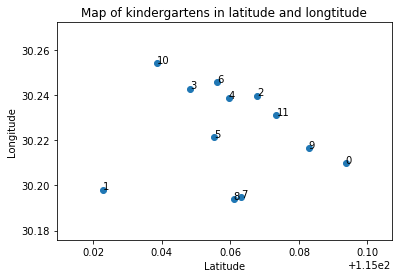

In [29]:
location = numpy.concatenate((location, new_location))
drawLocation(location)

In [30]:
start_point = [10, 7]
cluster = assignGroups(start_point, weight)
print(cluster)
for start in start_point:
    print(shortestTour(shortestTours(cluster[start]), cluster[start]))

{10: [10, 3, 6, 4, 2, 5], 7: [7, 8, 0, 9, 1, 11]}
(4, 5, 3, 10, 6, 2)
(0, 11, 9, 1, 7, 8)


In [31]:
def avoidNearType(near1, near2, curr):
    all_best_type = set(type_best)
    near_type = set(book_types[near1] +  book_types[near2])
    new_kin_best_type = all_best_type - near_type

    all_other_type = set(type_other)
    new_kin_other_type = all_other_type - near_type
    
    # choose new type
    new_kin_type = []
    if book_unit[curr] < 3:
        for i in range(book_unit[curr]):
            new_kin_type.append(new_kin_best_type.pop())
    else:
        for i in range(3):
            new_kin_type.append(new_kin_best_type.pop())
        for i in range(book_unit[curr]-3):
            new_kin_type.append(new_kin_other_type.pop())
    return(new_kin_type)

In [32]:
def assignAddKin(cluster):
    for i in range(len(new_unit)):
        for start in start_point:
            curr = num_kin - len(new_unit) + i
            if curr in cluster[start]:
                tour = shortestTour(shortestTours(cluster[start]), cluster[start])
                if tour[0] == curr:
                    near1 = tour[-1]
                    near2 = tour[1]
                elif tour[-1] == curr:
                    near1 = tour[-1]
                    near2 = tour[0]
                else:
                    curr_index = tour.index(curr)
                    near1 = tour[curr_index - 1]
                    near2 = tour[curr_index + 1]
                book_types[curr] = avoidNearType(near1, near2, curr)
    return(book_types)

In [33]:
assignAddKin(cluster)

{0: ['B1', 'B2', 'B3', 'O1', 'O2', 'O3'],
 1: ['B7', 'B8', 'B9'],
 2: ['B6', 'B7', 'B8', 'O4', 'O5'],
 3: ['B6', 'B7', 'B8', 'O3'],
 4: ['B1', 'B2', 'B3', 'O1', 'O2'],
 5: ['B4', 'B5'],
 6: ['B3', 'B4', 'B5'],
 7: ['B1', 'B2', 'B3'],
 8: ['B4', 'B5', 'B6'],
 9: ['B4', 'B5', 'B6'],
 10: ['B9', 'B1', 'B2'],
 11: ['B7', 'B9']}

In [34]:
instructions()

Kindergartens are clustered into 2 groups
Cluster 0 : (4, 5, 3, 10, 6, 2)
Truck starts from kindergarton 4
Truck picks up ['B1', 'B2', 'B3', 'O1', 'O2', 'O3'] from kindergarten 4
Truck travels to kindergarten 5, and loads off ['B1', 'B2']
Truck picks up ['B7', 'B8', 'B9'] from kindergarten 5
Truck travels to kindergarten 3, and loads off ['B3', 'O1', 'O2', 'B4']
Truck picks up ['B6', 'B7', 'B8', 'O4', 'O5'] from kindergarten 3
Truck travels to kindergarten 10, and loads off ['B5', 'B6', 'B7']
Truck picks up ['B6', 'B7', 'B8', 'O3'] from kindergarten 10
Truck travels to kindergarten 6, and loads off ['B8', 'O3', 'B9']
Truck picks up ['B1', 'B2', 'B3', 'O1', 'O2'] from kindergarten 6
Truck travels to kindergarten 2, and loads off ['B1', 'B2', 'B3', 'B4', 'B5']
Truck picks up ['B4', 'B5'] from kindergarten 2
Truck travels back to kindergarten 4, and loads off ['B6', 'B7', 'B8', 'O4', 'O5']
Traveling time through all kindergartens is: 39 min

Cluster 1 : (0, 11, 9, 1, 7, 8)
Truck starts fr